# IFT6135 Assignment 3
## Neural Turing Machines
### Roger Girgis, Alejandro Posada, and Matthew Scicluna

## 1) Filling in the gaps

### a) Transformation Functions

We implemented the Neural Turing machine described in [1]. The goal was to better understand attention and memory augmented networks, and the difficulties encountered when training them.

The output of the controller was a $100$ dimensional vector which we transformed into parameters used in the read and write heads and attention mechanism through single layer networks with different output tranformations. We chose output transformations such that their ranges matched the constraints of the parameters as described in the paper. We note that the choice in output tranformations matched those found in most implementations of Neural turing machines. If we denote as $M$ the size of the memory vector and $K$ as the allowed integer shift of the location based attentional mechanism, then the choice of transformation for each parameter can be found in the following table:

| Parameter    |Domain                        | Activation                |
|--------------|------------------------------|---------------------------|
| $\beta$      | $(0,\infty)$                 |  Softplus                 |
| $\kappa$     | $\mathbb{R}^M$               |  Identity                 |          
| $\gamma$     | $(1, \infty)$                |  1 + Softplus             |          
| $g$          | $(0,1)$                      |  Sigmoid                  |          
| $s$          |probablity simplex of size $K$|  Softmax$\circ$Softplus   |          
| $e$          | $\mathbb{R}^M$               |  Sigmoid                  |          
| $a$          | $\mathbb{R}^M$               |  Sigmoid                  |          

### b) Diagram

Presented below is a flow diagram showing the interaction between the following:

* the input $x_t$
* the memory $M_{t-1}$ and $M_t$
* the output of the read head $r_{t-1}$ and $r_t$
* the erase and add vectors $e_t$ and $a_t$
* the output of the controller $o_t$

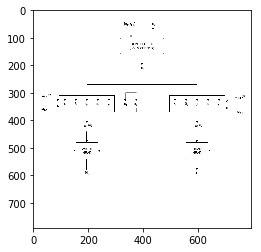

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('NTM_diagram.jpg')
imgplot = plt.imshow(img)
plt.show()

## 2) Implementing the Neural Turing Machine 

### a) Total number of parameters 
The total number of parameters of the LSTM baseline, the Feedforward-NTM and LSTM-NTM are shown in the table below.

|       Model        |     Number of parameters     |
|--------------------|------------------------------|
| LSTM baseline      | 45208                
| NTM-Feedforward    | 13381                    
| NTM-LSTM           | 62981                      

### b) Training
The three models were trained using cross-entropy loss and RMSProp with $\alpha=0.95$ and a momentum of $0.9$. The learning rates we used for each model are
* LSTM baseline: 0.001
* NTM-Feedforward: 0.0003
* NTM-LSTM: 0.003

The batch size was set to 16 and all models were initialized using the Xavier initializer [2]. For both NTM variants, we used a memory size $N=128$ and a memory feature size $M=20$. 

Below we present the learning curves: the cost per sequence and the loss (in terms of the binary cross-entropy computed during draining). We can see how both variants of NTM converge quickly (although NTM-MLP needs around 90000 more sequences than NTM-LSTM to reach zero loss) while the baseline fails to reach zero loss. As we will see, this will be reflected in the performance of the models.

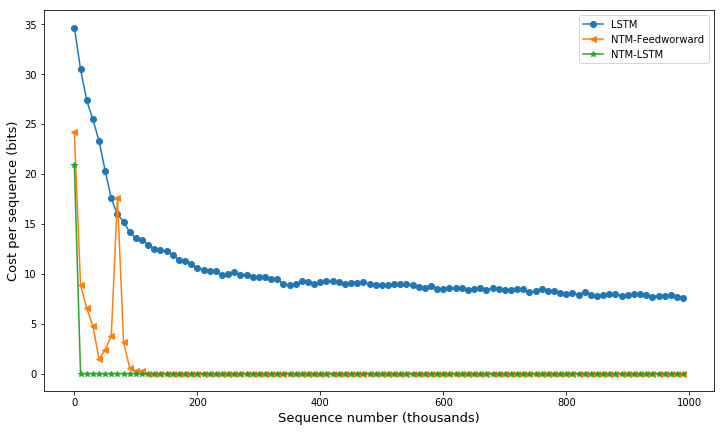

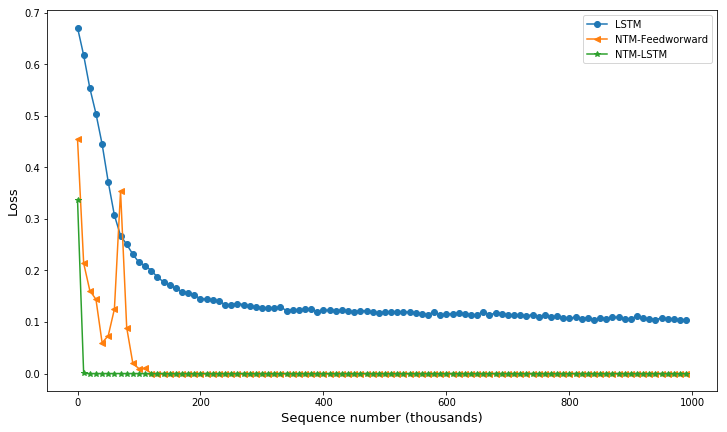

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from visualize_results import *
from train_utils import *
import warnings
warnings.filterwarnings('ignore')

# Trained models' checkpoints
ntm_mlp_checkpoint = 'checkpoints/ntm/copy-batch-62500.0--MLP.model'
ntm_lstm_checkpoint = 'checkpoints/ntm/copy-batch-62500.0--LSTM.model'
lstm_checkpoint = 'checkpoints/lstm/copy-batch-1000000.0.model'

fig, ax = plt.subplots(figsize=(12, 7))
plot_cost(lstm_checkpoint, 'LSTM', 10000, fig=fig, ax=ax)
plot_cost(ntm_mlp_checkpoint, 'NTM-Feedworward', 625, fig=fig, ax=ax, batch_size=16, marker='<')
plot_cost(ntm_lstm_checkpoint, 'NTM-LSTM', 625, fig=fig, ax=ax, batch_size=16, marker='*')
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))
plot_loss(lstm_checkpoint, 'LSTM', 10000, fig=fig, ax=ax)
plot_loss(ntm_mlp_checkpoint, 'NTM-Feedworward', 625, fig=fig, ax=ax, batch_size=16, marker='<')
plot_loss(ntm_lstm_checkpoint, 'NTM-LSTM', 625, fig=fig, ax=ax, batch_size=16, marker='*')
plt.show()

### c) Generalisation to longer sequences

We are now interested in the generalisation of the three models, i.e. we want to study their performance as a function of the sequence length $T$. First, we present visualisations of the inputs and outputs for each model for different values of $T \in \{10, 20, 30, 50, 100, 150\}$.

### c.i) NTM-LSTM

In [7]:
lengths = [10, 20, 30, 50, 100, 150]
for T in lengths:
    visualize_sequence(ntm_lstm_checkpoint, model_type='NTM', seq_len=T)

NameError: name 'visualize_sequence' is not defined

### c.ii) NTM-Feedforward

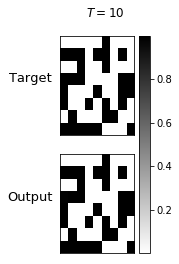

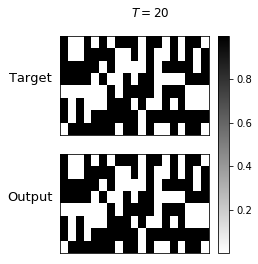

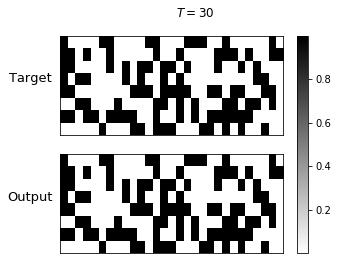

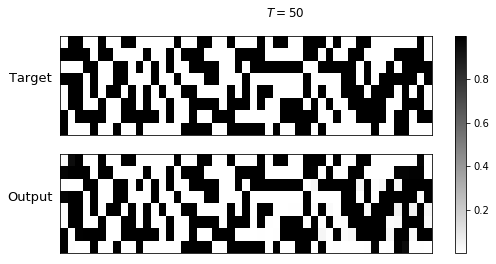

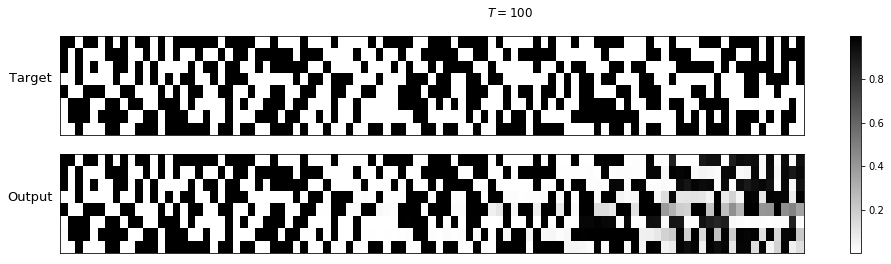

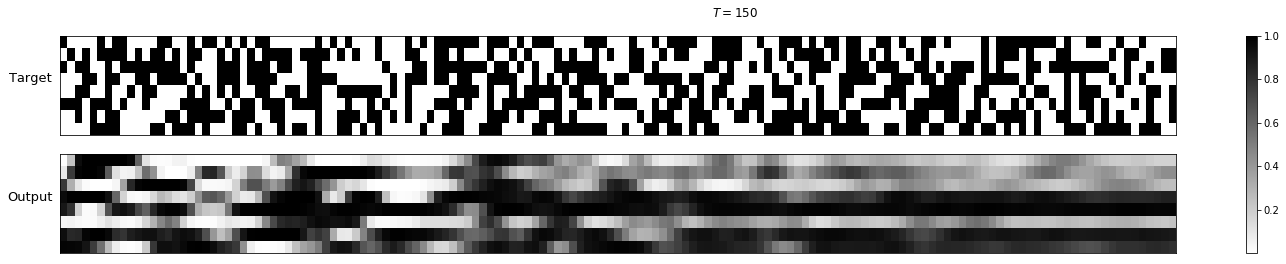

In [3]:
for T in lengths:
    visualize_sequence(ntm_mlp_checkpoint, model_type='NTM', seq_len=T)

### c.iii) LSTM

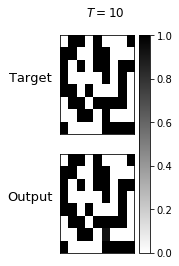

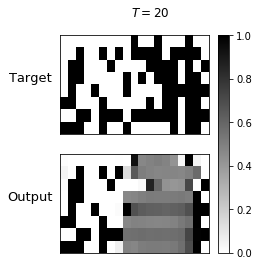

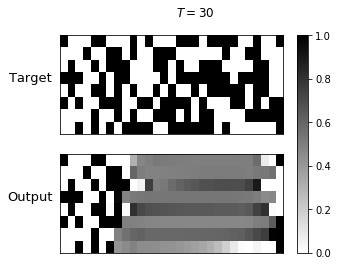

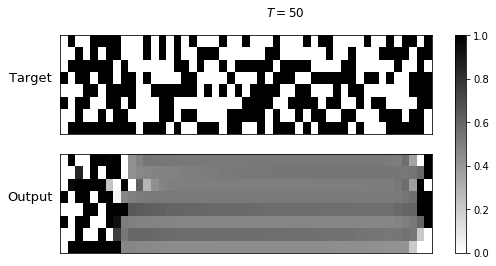

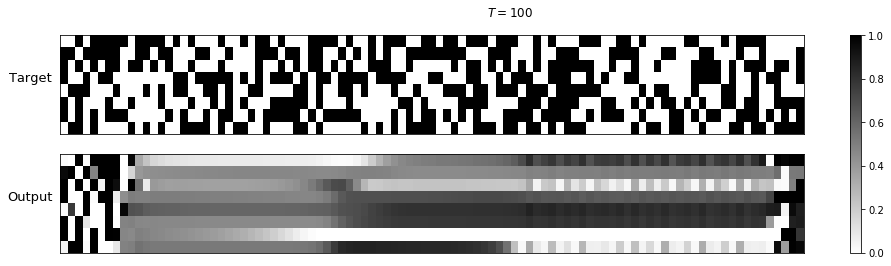

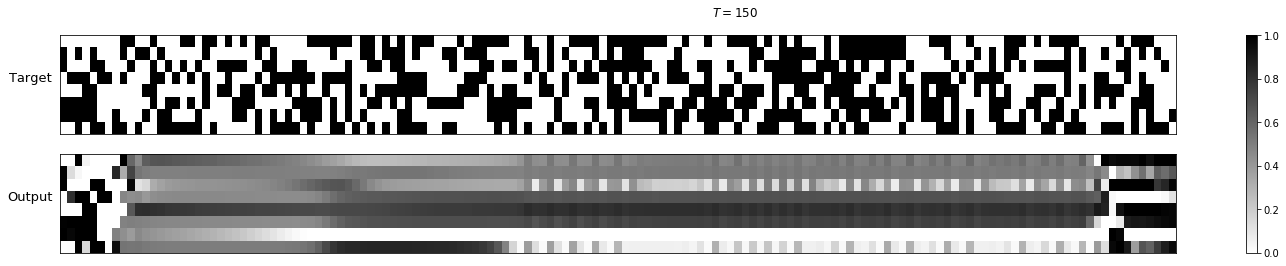

In [4]:
for T in lengths:
    visualize_sequence_v2(lstm_checkpoint, model_type='LSTM', seq_len=T)

We can see how NTM-LSTM performs well for sequences of length up to ~120. Long sequences ($T>120$) tend to be shifted and to produce soft outputs (i.e. predictions close to 0.5). On the other hand, the performance of NTM-Feedforward degrades faster but still presents no local errors nor shifts for sequences up to $T\approx90$. We observe that LSTM fails at copying sequences of length $T>10$. Surprisingly, for sequences $T\leq50$, the final two vectors of the sequence are copied almost perfectly. All in all, we were surprised to see how well NTM, in particular NTM-LSTM, performed and how bad the baseline generalises. We speculate that the poor performance of the baseline in comparison to the one reported in [1] is due to the fact that our LSTM has only one hidden of size 100, while the authors of [1] use 3 hidden layers of size 256.

Finally, we computed the cost with each model for $T \in \{10, 20, 30, 40, ..., 100 \}$ with 20 different inputs for each $T$. The figure below presents these results. We can see that the curves agree with the visualizations presented above: LSTM does not generalize to longer sequences and NTM-MLP's performance begins to degrade faster (i.e. with shorter sequences) than NTM-LSTM.  

In [2]:
# Compute the average cost over 20 runs for each model
costs, lengths = generalization_test()

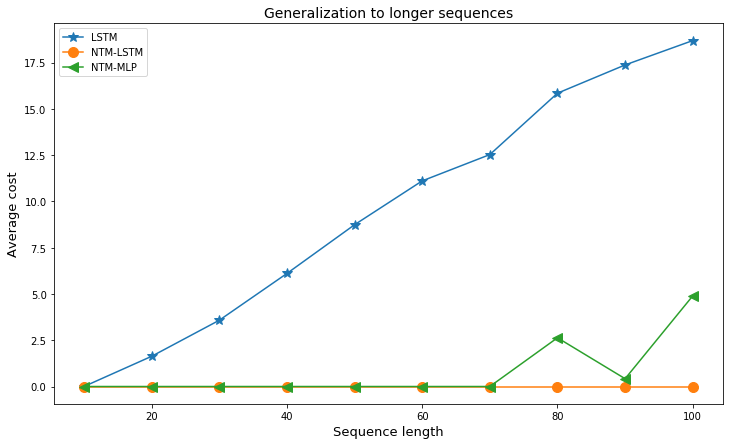

In [3]:
fig, ax = plt.subplots(figsize=(12, 7))
lengths = np.arange(10, 101, 10)

ax.plot(lengths, costs['lstm'], marker='*', markersize=10, label='LSTM')
ax.plot(lengths, costs['ntm_lstm'], marker='o', markersize=10, label='NTM-LSTM')
ax.plot(lengths, costs['ntm_mlp'], marker='<', markersize=10, label='NTM-MLP')
ax.legend()
ax.set_title('Generalization to longer sequences', fontsize=14)
ax.set_xlabel('Sequence length', fontsize=13)
ax.set_ylabel('Average cost', fontsize=13)
plt.show()

### d) Visualising the read and write heads/attention

We are now interested in visualizing the mechanism of addressing our memory. Specifically, we want to gain some insight on how the Neural Turing Machine produces the head weights (read or write) to focus on elements of its memory. After reading the paper [1], we would expect the model to learn the copying algorithm by first writing to specific locations in its memory, in a sequential fashion incrementing through a memory location each time it writes. Then, at the time of producing the output, it should refer to those same locations in memory to read from, passing through them in the same order it had written to them. 

Indeed, this is exactly what the model learns to do. This is visualized in the figure below where a sequence of ten inputs is provided to the model (plus the delimiter). An observation one could make is that when we are in the writing phase, the read head weights are scattered, i.e., there is no specific area in memory the read head focuses on. Once the model receives the delimiter input, it begins reading from a specific location (indicated by the first white rectangle in the "Read Head Weights" subplot). Interestingly, in contrast to the original paper, our model continues to write in memory the "zero" inputs that are fed at inference time, even after having received the delimiter signal. We hypothesize that the model continues to adjust its positioning in memory normally, but has learnt to make the erase and add vectors in the write head be zero-vectors after the delimiter signal has been received, avoiding any modifications to the memory.

/Users/rogergirgis/Documents/McGill Courses/IFT6135/assignment_3/IFT6135-A3/model.py:312: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  's': lambda x: F.softmax(F.softplus(x)),
/Users/rogergirgis/Documents/McGill Courses/IFT6135/assignment_3/IFT6135-A3/model.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(beta * F.cosine_similarity(memory + 1e-12, k + 1e-12, dim=-1))


<module 'matplotlib.pyplot' from '/Users/rogergirgis/pytorch/lib/python3.6/site-packages/matplotlib/pyplot.py'>

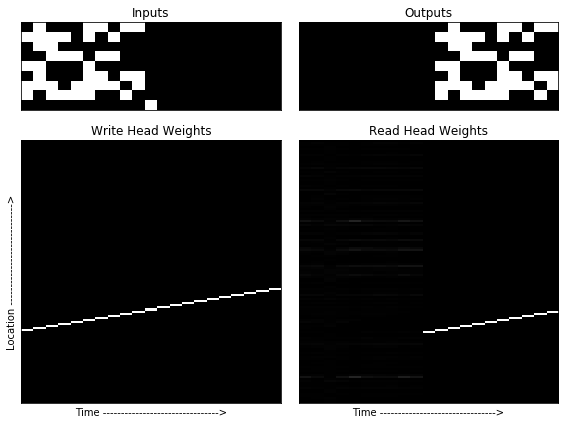

In [17]:
from visualize_results import visualize_heads, visualize_sequence
checkpoint = 'checkpoints/ntm/copy-batch-1125.0--LSTM.model'
visualize_heads(checkpoint=checkpoint)

Having understood the read-write heads, and how the model increments a location in memory before writing, we can now further our understanding of part c.i). We can explain the deterioration in performance at sequence lengths above >127 as occuring because the model is overwriting those locations in memory. Indeed, visualizing sequences of length 127 and 128 (shown below), we can see that the model perfectly fits the inputs for the former but fails to output the correct sequence of the latter (at the very least, by a shift in the output sequence). Furthermore, for a sequence of length 128, one could notice that the first element of the output sequence is a weighted combination of the first and last elements of the input sequence, which is in agreement with what we have observed from the read and write heads.

/Users/rogergirgis/Documents/McGill Courses/IFT6135/assignment_3/IFT6135-A3/model.py:312: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  's': lambda x: F.softmax(F.softplus(x)),
/Users/rogergirgis/Documents/McGill Courses/IFT6135/assignment_3/IFT6135-A3/model.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(beta * F.cosine_similarity(memory + 1e-12, k + 1e-12, dim=-1))


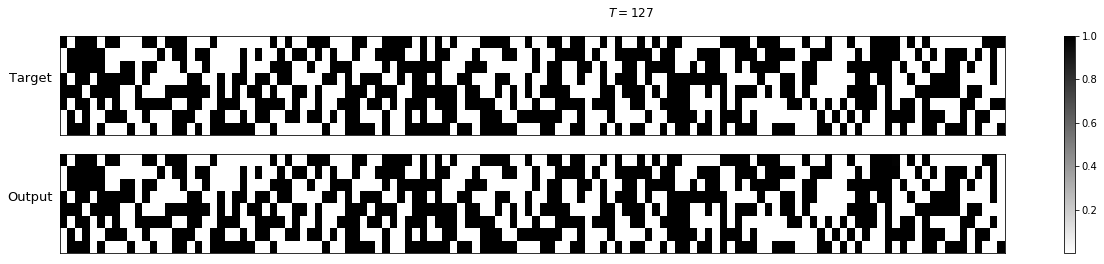

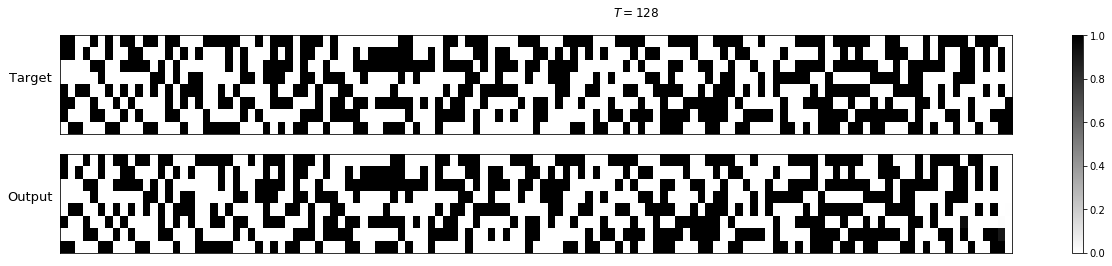

In [16]:
visualize_sequence(checkpoint, model_type='NTM', seq_len=127)
visualize_sequence(checkpoint, model_type='NTM', seq_len=128)

## Shift Operator and Convolutions
The shift operator is a $1$ dimensional convolution with size equal to the number of allowed integer shifts.
We modify the code-base so that the shift operator only allows forward shifts. The original code is as follows:

In [4]:
def shift_convolve(self, w_s, s, int_shift):
    window_length = int_shift*2 + 1
    assert s.size(0) == window_length
    t = torch.cat([w_s[-window_length+1:], w_s, w_s[:window_length-1]])
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    return c[int_shift:-int_shift]

The code modified to only allow forward shifts is as follows:

In [10]:
def shift_forward(self, w_s, s, int_shift):
    window_length = int_shift
    assert s.size(0) == window_length
    t = torch.cat([w_s[window_length:], w_s[:window_length]])
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    return c

We provide a minimal working example to demonstrate the difference between the two operators. The shift operator described in [1] is a convolution and it computes $w(i)$ as a linear combination of the previous $w(j)$ where $j \in \{ i, i-1, i+1, \cdots, i-k, i+k \}$, where $k$ is the allowed integer shift. Notice that this setup allows for $w(i)$ to be influenced by $w(j)$ for $j\le i$. In order for the shift operator to only allow for forward shifts we can simply set $s(i)=0$ for $i\le k+1$. Equivalently, we simply apply a convolution of size $k$ to each entry shifted over by $k$ to get our desired effect.

We apply a uniform convolution with $k=1$ over the sequence $0$ to $6$ for demonstrative purposes. It can be easily seen that the convolution leaves the middle unaffected (since $\frac{j-1}{3} + \frac{j}{3} + \frac{j+1}{3} = j$) and causes the end values to change considerably due to the modulo (for example: $\frac{6}{3} + \frac{0}{3} + \frac{1}{3} = \frac{7}{3}$)

In [13]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable

w_s = Variable(torch.FloatTensor(np.arange(7)))
int_shift = 1

s = Variable(torch.ones(2*int_shift+1)/(2*int_shift+1))
new_ws = shift_convolve(None, w_s, s, int_shift)
print(w_s.data)
print(new_ws.data)
# w_s convolved in both directions, and so middle values unchanged and values at end average out


 0
 1
 2
 3
 4
 5
 6
[torch.FloatTensor of size 7]


 2.3333
 1.0000
 2.0000
 3.0000
 4.0000
 5.0000
 3.6667
[torch.FloatTensor of size 7]



We test our implementation of the shift operator on the same sequence, but with a shift of $1$. As expected, the shift does exactly what you would expect it to do.

In [14]:
s = Variable(torch.ones(int_shift)/(int_shift))
new_ws = shift_forward(None, w_s, s, int_shift)
print(w_s.data)
print(new_ws.data)
# w_s convolved only in forward direction so values increase by 1


 0
 1
 2
 3
 4
 5
 6
[torch.FloatTensor of size 7]


 1
 2
 3
 4
 5
 6
 0
[torch.FloatTensor of size 7]



## References

[1] Alex Graves, Greg Wayne, and Ivo Danihelka. Neural turing machines. arXiv preprint
arXiv :1410.5401, 2014.

[2] Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Proceedings of the thirteenth international conference on artificial intelligence and statistics. 2010.